In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

In [116]:
# Define the paths to the image folder and annotations
images_path = "../Potholes/annotated-images"
annotations_path = "../Potholes/annotated-images"
# Edge Boxes parameters
EDGE_BOXES_PARAMS = {
    "alpha": 0.8,       # Finer granularity in sliding window
    "beta": 0.6,        # Increased sensitivity to edge density
    "minScore": 0.05,   # Minimum score for boxes
    "maxBoxes": 200     # Allow more proposals for potential potholes
}



In [117]:
# Helper function to parse the XML file for ground truth bounding boxes
def parse_xml(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    boxes = []
    
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))
    
    return boxes

In [118]:
def get_edge_boxes(image, model_path="model.yml.gz"):
    # Set up Edge Boxes
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(EDGE_BOXES_PARAMS["maxBoxes"])
    edge_boxes.setAlpha(EDGE_BOXES_PARAMS["alpha"])
    edge_boxes.setBeta(EDGE_BOXES_PARAMS["beta"])
    edge_boxes.setMinScore(EDGE_BOXES_PARAMS["minScore"])
    
    # Load the Structured Edge Detection model
    edge_detector = cv2.ximgproc.createStructuredEdgeDetection(model_path)
    
    # Convert image to RGB and then to 32-bit floating point
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb = image_rgb.astype(np.float32) / 255.0  # Convert to [0,1] range and 32-bit float

    # Detect edges and compute orientation map
    edges = edge_detector.detectEdges(image_rgb)
    orientation_map = edge_detector.computeOrientation(edges)
    
    # Generate Edge Boxes proposals using both edge map and orientation map
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orientation_map)
    edge_boxes_list = [(x, y, w, h) for [x, y, w, h] in boxes]
    return edge_boxes_list


In [119]:
# Helper function to display an image with ground truth and Edge Boxes proposals
def visualize_image_with_proposals(image_file, gt_boxes, proposals):
    image = cv2.imread(image_file)
    if image is None:
        print(f"Error: Could not load image at {image_file}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw ground truth boxes in blue
    for (xmin, ymin, xmax, ymax) in gt_boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Draw Edge Boxes proposals in green
    for (x, y, w, h) in proposals:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Processing: ../Potholes/annotated-images\img-1.jpg


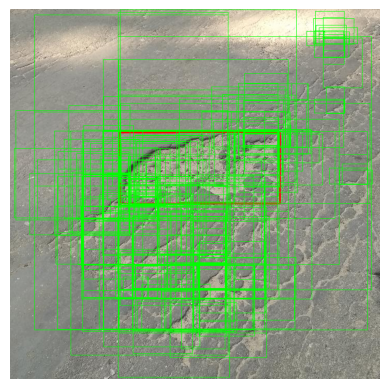

Processing: ../Potholes/annotated-images\img-10.jpg


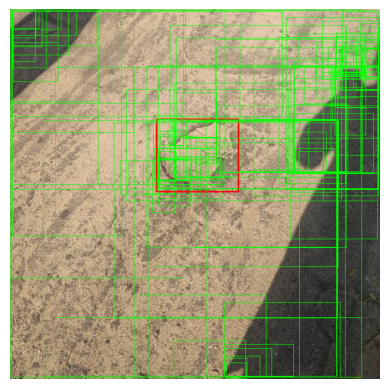

Processing: ../Potholes/annotated-images\img-100.jpg


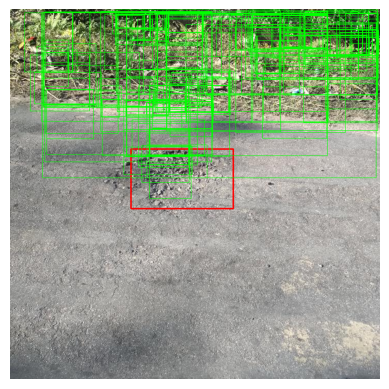

Processing: ../Potholes/annotated-images\img-101.jpg


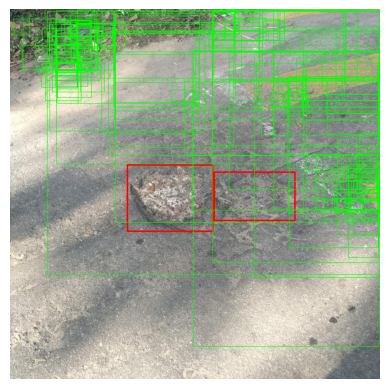

Processing: ../Potholes/annotated-images\img-102.jpg


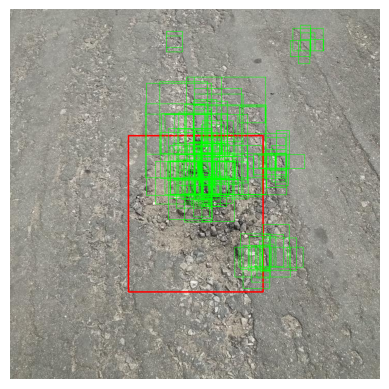

Processing: ../Potholes/annotated-images\img-103.jpg


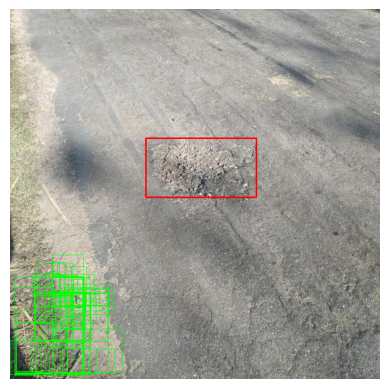

Processing: ../Potholes/annotated-images\img-104.jpg


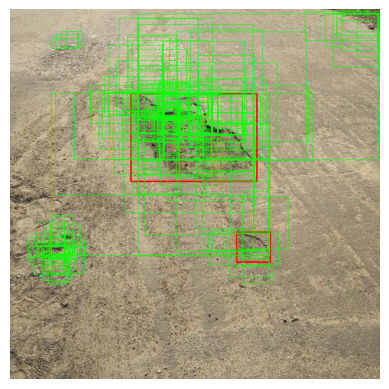

Processing: ../Potholes/annotated-images\img-105.jpg


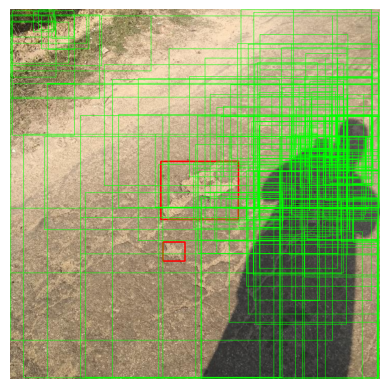

Processing: ../Potholes/annotated-images\img-106.jpg


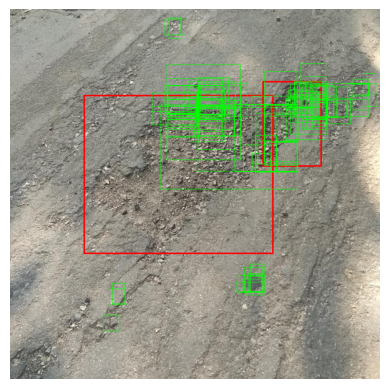

Processing: ../Potholes/annotated-images\img-107.jpg


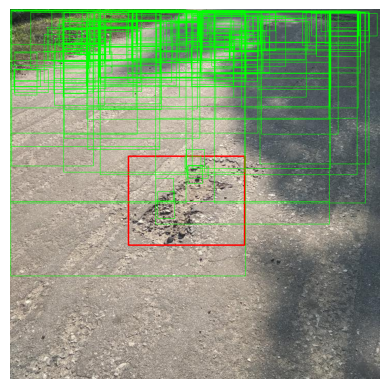

Processing: ../Potholes/annotated-images\img-108.jpg


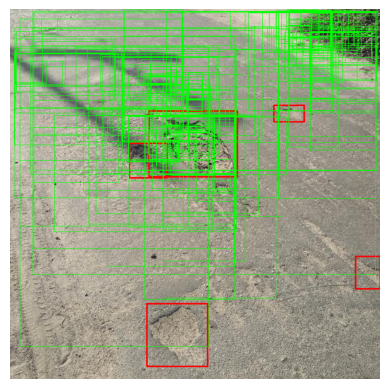

In [120]:
# Main loop to process images, parse XML, and generate Edge Boxes proposals
for image_filename in os.listdir(images_path):
    if image_filename.endswith(".jpg"):
        image_path = os.path.join(images_path, image_filename)
        xml_filename = image_filename.replace(".jpg", ".xml")
        xml_path = os.path.join(annotations_path, xml_filename)
        
        print("Processing:", image_path)
        
        # Check if XML file exists and parse ground truth boxes
        if os.path.exists(xml_path):
            gt_boxes = parse_xml(xml_path)
        else:
            print(f"Warning: Annotation file {xml_path} does not exist.")
            gt_boxes = []
        
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image at {image_path}")
            continue
        
        # Generate Edge Boxes proposals
        edge_boxes_proposals = get_edge_boxes(image, model_path="model.yml")
        
        # Visualize both ground truth boxes and Edge Boxes proposals
        visualize_image_with_proposals(image_path, gt_boxes, edge_boxes_proposals)
        
        # Display only a few examples for familiarity
        if len(gt_boxes) > 2:
            break  # Remove this line if you want to display more images

## TO DO: IMPLEMENT METRICS